In [1]:
import xarray as xr
import torch
import torch.nn as nn
from torch import tensor
from torch.utils.data import random_split, Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from typing import Tuple
import numpy as np
import zarr
import pandas as pd
import cftime
import yaml
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error


def r2_score_multi(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """Calculated the r-squared score between 2 arrays of values

    :param y_pred: predicted array
    :param y_true: "truth" array
    :return: r-squared metric
    """
    return r2_score(y_pred.flatten(), y_true.flatten())


with open(f"../config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Set rollout length
ROLLOUT=4  # 12
torch.cuda.empty_cache()

In [2]:
CONFIG

{'clim_feats': ['clim_clake',
  'clim_ldepth',
  'clim_ctype',
  'clim_cell_area',
  'clim_landsea',
  'clim_glm',
  'clim_cu',
  'clim_cvh',
  'clim_cvl',
  'clim_geopot',
  'clim_sdfor',
  'clim_sdor',
  'clim_theta_cap',
  'clim_theta_pwp',
  'clim_veg_covh',
  'clim_veg_covl',
  'clim_veg_z0mh',
  'clim_veg_z0ml',
  'clim_veg_rsminh',
  'clim_veg_rsminl'],
 'dynamic_feats': ['met_ctpf',
  'met_lwdown',
  'met_psurf',
  'met_qair',
  'met_rainf',
  'met_swdown',
  'met_snowf',
  'met_tair',
  'met_wind_e',
  'met_wind_n',
  'lai_hv',
  'lai_lv'],
 'targets_prog': ['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc'],
 'targets_diag': ['d2m', 't2m', 'skt'],
 'file_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h.zarr',
 'start_year': 2015,
 'end_year': 2020,
 'validation_start': 2021,
 'validation_end': 2021,
 'x_slice_indices': [0, 'None'],
 'roll_out': 6,
 'batch_size': 4,
 'num_workers': 16,
 'hidden_dim': 172,
 'max_epochs': 250,
 'strategy':

In [3]:
# Set device
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [4]:
# Inspect dataset and variables
da = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr")
da

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 25GB
Dimensions:                     (x: 10051, clim_variable: 23, time: 18744,
                                 variable: 33)
Coordinates:
  * clim_variable               (clim_variable) object 184B 'clim_cell_area' ...
    lat                         (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
    lon                         (x) float32 40kB dask.array<chunksize=(10051,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 150kB 2010-02-01 ... 20...
  * variable                    (variable) object 264B 'met_ctpf' ... 'es'
  * x                           (x) int32 40kB 15653 16004 ... 128483 128484
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 925kB dask.array<chunksize=(10051, 23), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    data                        (time, x, variable) float32 25GB dask.array<chunksize=(4, 10051, 33), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_means           (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_mins            (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 1MB dask.array<chunksize=(10051, 33), meta=np.ndarray>

In [5]:
class EcDataset(Dataset):
    # load the dataset
    def __init__(
        self,
        start_yr=2015,
        end_yr=2020,
        x_idxs=(0, "None"),
        path="/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr",
        roll_out=ROLLOUT,
    ):
        self.ds_ecland = zarr.open(path)
        # Create time index to select appropriate data range
        date_times = pd.to_datetime(
            cftime.num2pydate(
                self.ds_ecland["time"], self.ds_ecland["time"].attrs["units"]
            )
        )
        self.start_index = min(np.argwhere(date_times.year == int(start_yr)))[0]
        self.end_index = max(np.argwhere(date_times.year == int(end_yr)))[0]
        self.times = np.array(date_times[self.start_index : self.end_index])
        self.len_dataset = self.end_index - self.start_index

        # Select points in space
        self.x_idxs = (0, None) if "None" in x_idxs else x_idxs
        self.x_size = len(self.ds_ecland["x"][slice(*self.x_idxs)])
        self.lats = self.ds_ecland["lat"][slice(*self.x_idxs)]
        self.lons = self.ds_ecland["lon"][slice(*self.x_idxs)]

        # List of climatological time-invariant features
        self.static_feat_lst = CONFIG["clim_feats"]
        self.clim_index = [
            list(self.ds_ecland["clim_variable"]).index(x) for x in CONFIG["clim_feats"]
        ]
        # List of features that change in time
        self.dynamic_feat_lst = CONFIG["dynamic_feats"]
        self.dynamic_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["dynamic_feats"]
        ]
        # Prognostic target list
        self.targ_lst = CONFIG["targets_prog"]
        self.targ_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["targets_prog"]
        ]
        # Diagnostic target list
        self.targ_diag_lst = CONFIG["targets_diag"]
        self.targ_diag_index = [
            list(self.ds_ecland["variable"]).index(x) for x in CONFIG["targets_diag"]
        ]

        # Define the statistics used for normalising the data
        self.x_dynamic_means = tensor(self.ds_ecland.data_means[self.dynamic_index])
        self.x_dynamic_stdevs = tensor(self.ds_ecland.data_stdevs[self.dynamic_index])

        # Create time-invariant static climatological features
        x_static = tensor(
            self.ds_ecland.clim_data[slice(*self.x_idxs), self.clim_index]
        )
        clim_means = tensor(self.ds_ecland.clim_means[self.clim_index])
        clim_stdevs = tensor(self.ds_ecland.clim_stdevs[self.clim_index])
        self.x_static_scaled = self.transform(
            x_static, clim_means, clim_stdevs
        ).reshape(1, self.x_size, -1)

        # Define statistics for normalising the targets
        self.y_prog_means = tensor(self.ds_ecland.data_means[self.targ_index])
        self.y_prog_stdevs = tensor(self.ds_ecland.data_stdevs[self.targ_index])

        self.y_diag_means = tensor(self.ds_ecland.data_means[self.targ_diag_index])
        self.y_diag_stdevs = tensor(self.ds_ecland.data_stdevs[self.targ_diag_index])

        self.rollout = roll_out

    def transform(self, x: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        """Transform data with mean and stdev.

        :param x: data :param mean: mean :param std: standard deviation :return:
        normalised data
        """
        x_norm = (x - mean) / (std + 1e-5)
        return x_norm

    def inv_transform(
        self, x_norm: np.ndarray, mean: np.ndarray, std: np.ndarray
    ) -> np.ndarray:
        """Inverse transform on data with mean and stdev.

        :param x_norm: normlised data :param mean: mean :param std: standard deviation
        :return: unnormalised data
        """
        x = (x_norm * (std + 1e-5)) + mean
        return x

    def load_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Load data into memory. **CAUTION ONLY USE WHEN WORKING WITH DATASET THAT FITS
        IN MEM**

        :return: static_features, dynamic_features, prognostic_targets,
        diagnostic_targets
        """
        ds_slice = tensor(
            self.ds_ecland.data[
                self.start_index : self.end_index, slice(*self.x_idxs), :
            ]
        )

        X = ds_slice[:, :, self.dynamic_index]
        X = self.transform(X, self.x_dynamic_means, self.x_dynamic_stdevs)

        X_static = self.x_static_scaled

        Y_prog = ds_slice[:, :, self.targ_index]
        Y_prog = self.transform(Y_prog, self.y_prog_means, self.y_prog_stdevs)

        Y_diag = ds_slice[:, :, self.targ_diag_index]
        Y_diag = self.transform(Y_diag, self.y_diag_means, self.y_diag_stdevs)
        return X_static, X, Y_prog, Y_diag

    # number of rows in the dataset
    def __len__(self):
        return self.len_dataset - 1 - self.rollout

    # get a row at an index
    def __getitem__(self, idx):
        idx = idx + self.start_index
        ds_slice = tensor(
            self.ds_ecland.data[
                slice(idx, idx + self.rollout + 1), slice(*self.x_idxs), :
            ]
        )

        X = ds_slice[:, :, self.dynamic_index]
        X = self.transform(X, self.x_dynamic_means, self.x_dynamic_stdevs)

        X_static = self.x_static_scaled.expand(self.rollout, -1, -1)

        Y_prog = ds_slice[:, :, self.targ_index]
        Y_prog = self.transform(Y_prog, self.y_prog_means, self.y_prog_stdevs)

        Y_diag = ds_slice[:, :, self.targ_diag_index]
        Y_diag = self.transform(Y_diag, self.y_diag_means, self.y_diag_stdevs)

        Y_inc = Y_prog[1:, :, :] - Y_prog[:-1, :, :]
        return X_static, X[:-1], Y_prog[:-1], Y_inc, Y_diag[:-1]
    
    # get indexes for train and test rows
    def get_splits(self, n_test=0.2):
        # determine sizes
        generator = torch.Generator().manual_seed(42)
        test_size = round(n_test * (self.len_dataset-1-self.rollout)) 
        train_size = (self.len_dataset-1-self.rollout) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size], generator=generator)


class NonLinRegDataModule(pl.LightningDataModule):
    """Pytorch lightning specific data class."""
    def setup(self, stage):
        generator = torch.Generator().manual_seed(42)
        training_data = EcDataset()
        self.train, self.test = training_data.get_splits()

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=50, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.test, batch_size=50, shuffle=False, num_workers=8)


In [6]:
# Define a neural network model with hidden layers and activation functions
class NonLinearRegression(pl.LightningModule):
    def __init__(
        self,
        input_size_clim,
        input_size_met,
        input_size_state,
        hidden_size,
        output_size,
        mu_norm=0,
        std_norm=1,
        dataset=None,
    ):
        super().__init__()
        # Normalization vector for delta_x's
        self.mu_norm = tensor(mu_norm)
        self.std_norm = tensor(std_norm)
        self.ds = dataset

        # Define layers
        input_dim = input_size_clim + input_size_met + input_size_state

        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.15)
        self.relu3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, clim_feats, met_feats, state_feats):
        combined = torch.cat((clim_feats, met_feats, state_feats), dim=-1)
        x = self.relu1(self.fc1(combined))
        x = self.dropout(self.relu2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

    def transform(self, x, mean, std):
        x_norm = (x - mean) / (std + 1e-5)
        # x_norm = (x - mean) / (std)
        return x_norm

    def predict_step(
        self, clim_feats, met_feats, states, diagnostics
    ) -> Tuple[tensor, tensor]:
        """Given arrays of features produces a prediction for all timesteps.

        :return: (prognost_targets, diagnostic_targets)
        """
        preds = states.clone().to(self.device)
        len_run = preds.shape[0]

        for x in range(len_run):
            preds_dx = self.forward(
                clim_feats, met_feats[[x]], preds[[x]]
            )
            if x < (len_run - 1):
                preds[x + 1] = preds[x] + preds_dx
        return preds

    def MSE_loss(self, logits, labels):
        # criterion = nn.MSELoss()
        criterion = nn.SmoothL1Loss()
        return criterion(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x_clim, x_met, x_state, y, _ = train_batch
        logits = self.forward(x_clim, x_met, x_state)
        mean = self.mu_norm.to(self.device)
        std = self.std_norm.to(self.device)
        loss = self.MSE_loss(
            self.transform(logits, mean, std), self.transform(y, mean, std)
        )
        self.log(
            "train_loss",
            loss,
        )

        if ROLLOUT > 1:
            x_state_rollout = x_state.clone()
            y_rollout = y.clone()
            for step in range(ROLLOUT):
                # x = [batch_size=8, lookback (7) + rollout (3) = 10, n_feature = 37]
                x0 = x_state_rollout[:, step, :, :].clone()  # select input with lookback.
                y_hat = self.forward(
                    x_clim[:, step, :, :], x_met[:, step, :, :], x0
                )  # prediction at rollout step
                if step < ROLLOUT - 1:
                    x_state_rollout[:, step + 1, :, :] = (
                        x_state_rollout[:, step, :, :].clone() + y_hat
                    )  # overwrite x with prediction.
                y_rollout[:, step, :, :] = y_hat  # overwrite y with prediction.
            step_loss = self.MSE_loss(
                self.transform(y_rollout, mean, std), self.transform(y, mean, std)
            )
            # step_loss = step_loss / ROLLOUT
            self.log(
                "step_loss",
                step_loss,
            )

            loss += step_loss

        return loss

    def validation_step(self, val_batch, batch_idx):
        x_clim, x_met, x_state, y, _ = val_batch
        mean = self.mu_norm.to(self.device)
        std = self.std_norm.to(self.device)
        logits = self.forward(x_clim, x_met, x_state)
        loss = self.MSE_loss(
            self.transform(logits, mean, std), self.transform(y, mean, std)
        )
        r2 = r2_score_multi(
            self.transform(logits, mean, std).cpu(),
            self.transform(y, mean, std).cpu(),
        )
        self.log("val_loss", loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log("val_R2", r2, on_step=False, on_epoch=True, sync_dist=True)

        if ROLLOUT > 1:
            x_state_rollout = x_state.clone()
            y_rollout = y.clone()
            for step in range(ROLLOUT):
                # x = [batch_size=8, lookback (7) + rollout (3) = 10, n_feature = 37]
                x0 = x_state_rollout[
                    :, step, :, :
                ].clone()  # select input with lookback.
                y_hat = self.forward(
                    x_clim[:, step, :, :], x_met[:, step, :, :], x0
                )  # prediction at rollout step
                if step < ROLLOUT - 1:
                    x_state_rollout[:, step + 1, :, :] = (
                        x_state_rollout[:, step, :, :].clone() + y_hat
                    )  # overwrite x with prediction.
                y_rollout[:, step, :, :] = y_hat  # overwrite y with prediction.
            step_loss = self.MSE_loss(
                self.transform(y_rollout, mean, std), self.transform(y, mean, std)
            )
            # step_loss = step_loss / ROLLOUT
            self.log(
                "val_step_loss",
                step_loss,
            )
            loss += step_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [7]:
# load the dataset
ds_example = EcDataset()
print(ds_example.__len__())

# calculate split
train, test = ds_example.get_splits()

# prepare data loaders
train_dl = DataLoader(train, batch_size=10, shuffle=True)  # shuffle=False)
test_dl = DataLoader(test, batch_size=10, shuffle=False)

# inspect shape of a single batch, should be (batch_size, rollout_size, x_dim_size, feat/targ_size)
_, xx, _, yy, _ = next(iter(train_dl))
print(xx.shape)
print(yy.shape)

8762
torch.Size([10, 4, 10051, 12])
torch.Size([10, 4, 10051, 7])


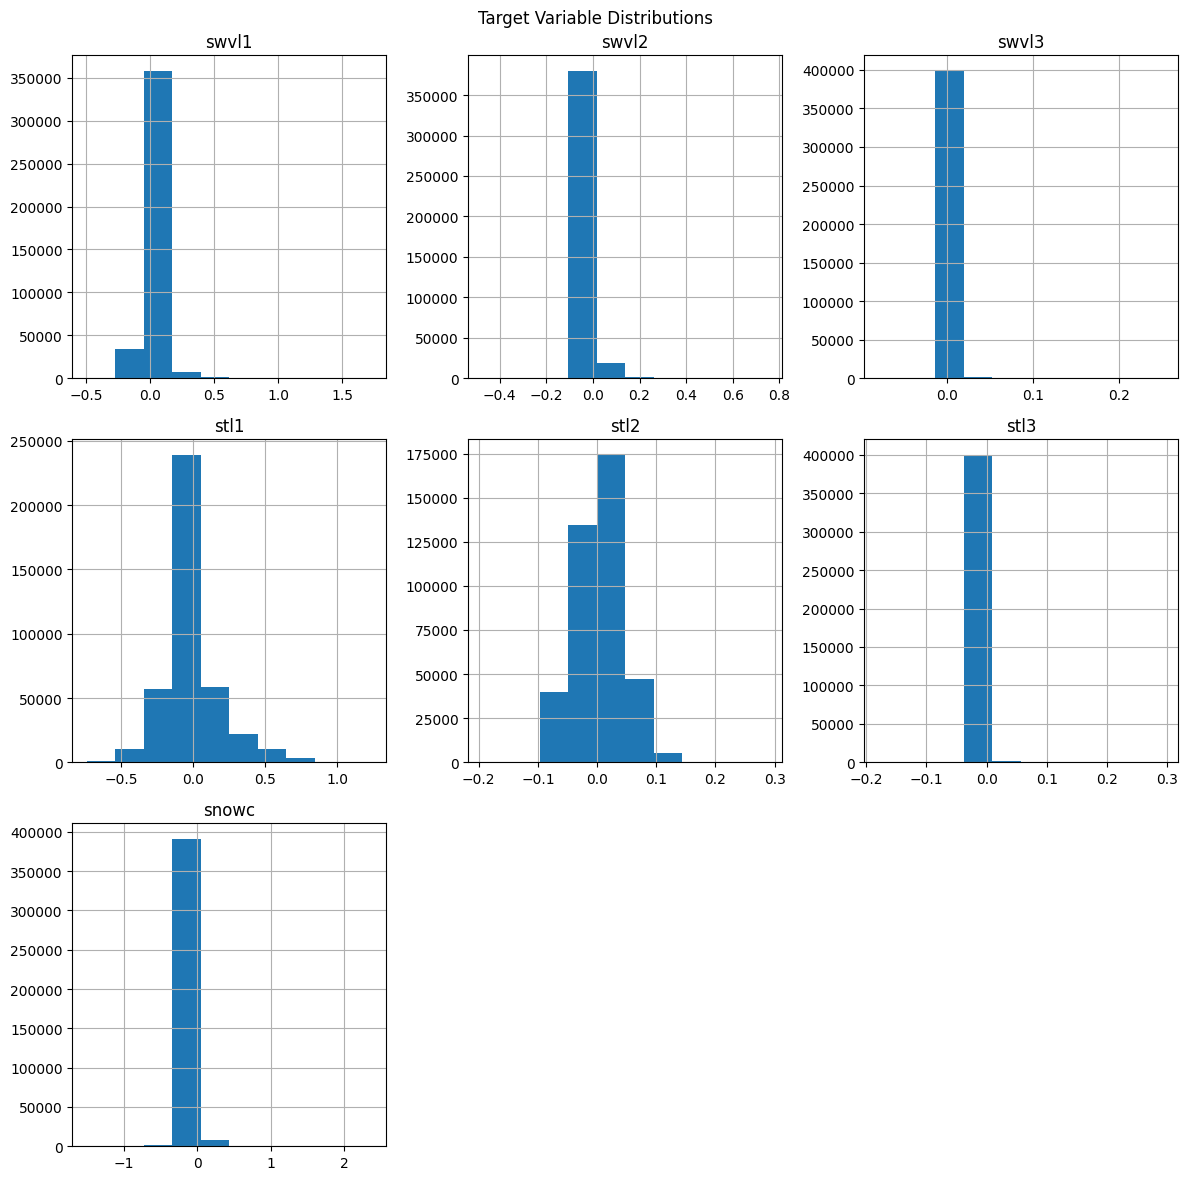

In [8]:
import pandas as pd

std = ds_example.y_prog_stdevs.cpu().numpy()
ds_mean = ds_example.ds_ecland.data_1stdiff_means[ds_example.targ_index] / (std + 1e-5)
ds_std = ds_example.ds_ecland.data_1stdiff_stdevs[ds_example.targ_index] / (std + 1e-5)

#df = pd.DataFrame(yy.reshape(-1, len(ds_example.targ_lst)).cpu().numpy() / (ds_std), columns=ds_example.targ_lst)
df = pd.DataFrame(yy.reshape(-1, len(ds_example.targ_lst)).cpu().numpy(), columns=ds_example.targ_lst)
df.hist(figsize=(12,12),)
plt.suptitle("Target Variable Distributions")
plt.tight_layout()

del ds_example, xx, yy

In [9]:
from pytorch_lightning.loggers import CSVLogger

data_module = NonLinRegDataModule()
dataset = EcDataset()
csv_logger = CSVLogger('logs', name='testing')  # Change 'logs' to the directory where you want to save the logs

std = dataset.y_prog_stdevs.cpu().numpy()
ds_mean = dataset.ds_ecland.data_1stdiff_means[dataset.targ_index] / (std + 1e-5)
ds_std = dataset.ds_ecland.data_1stdiff_stdevs[dataset.targ_index] / (std + 1e-5)

# train
input_clim_dim = dataset.x_static_scaled.shape[-1]
input_met_dim = len(dataset.dynamic_feat_lst)
input_state_dim = len(dataset.targ_lst)
output_dim = len(dataset.targ_lst)  # Number of output targets
hidden_dim = 172  # Number of hidden units
model_pyt = NonLinearRegression(
    input_clim_dim,
    input_met_dim,
    input_state_dim,
    hidden_dim,
    output_dim,
    mu_norm=ds_mean,
    std_norm=ds_std,
    dataset=dataset,
)

In [10]:
torch.cuda.empty_cache()
torch.set_float32_matmul_precision("high")
checkpoint_callback = ModelCheckpoint(monitor="val_step_loss", mode="min")
# torch.set_float32_matmul_precision('medium')
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    # precision='bf16-mixed',
    logger=csv_logger,
    max_epochs=50,  # 40  # 100,  # 200,
)

trainer.fit(model_pyt, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | fc1     | Linear    | 6.9 K 
1 | relu1   | ReLU      | 0     
2 | fc2     | Linear    | 29.8 K
3 | relu2   | LeakyReLU | 0     
4 | fc3     | Linear    | 29.8 K
5 | dropout | Dropout   | 0     
6 | relu3   | LeakyReLU | 0     
7 | fc4     | Linear    | 1.2 K 
--------------------------------------
67.6 K    Trainable params
0         Non-trainable params
67.6 K    Total params
0.270     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


# Testing out the trained model

In [11]:
model_pyt.eval()
test_ds = EcDataset(start_yr="2018", 
                    end_yr="2022", 
                    path="/perm/daep/ec_land_db_test/ecland_i6aj_2018_2022_6H.zarr",
                    x_idxs=(500-4, 500+4))
feats = test_ds.ds_ecland[dataset.dynamic_feat_lst].isel(x=4, time=slice(0,-1)).compute()
feats_arr2 = np.array(feats.to_array().values.T)

KeyError: '.zgroup'

In [ ]:
test_ds.ds_ecland.x

<xarray.DataArray 'x' (x: 8)> Size: 32B
array([60869, 60870, 60871, 60872, 60873, 60874, 60875, 60876], dtype=int32)
Coordinates:
    lat      (x) float32 32B dask.array<chunksize=(8,), meta=np.ndarray>
    lon      (x) float32 32B dask.array<chunksize=(8,), meta=np.ndarray>
  * x        (x) int32 32B 60869 60870 60871 60872 60873 60874 60875 60876
Attributes:
    long_name:  grid points
    units:      -

In [ ]:
model_pyt.cpu()

NonLinearRegression(
  (fc1): Linear(in_features=31, out_features=172, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=172, out_features=172, bias=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=172, out_features=172, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (fc4): Linear(in_features=172, out_features=7, bias=True)
)

In [ ]:
test_ds.X_static_scaled.shape

torch.Size([1, 8, 12])

In [ ]:
%%time
# Loop over all times and iteratively apply the ML model to construct a 5-year ML estimate to the ec-land model
feats_arr3 = dataset.dynamic_feat_scalar.transform(
    tensor(feats_arr2, dtype=torch.float32))#.reshape(1, -1, 19)  # .to(device)
static_feats = test_ds.X_static_scaled[:,4,:]
print(feats_arr3.shape)

for x in range(len(feats_arr2)-1):
    if x % 1000 == 0:
        print(f"on step {x}...")
    with torch.no_grad():
        preds = model_pyt(torch.cat((static_feats, feats_arr3[[x]]), axis=-1))
        feats_arr3[x+1, -len(dataset.targ_lst):] = feats_arr3[x, -len(dataset.targ_lst):] + preds
        
feats_arr3 = dataset.dynamic_feat_scalar.inv_transform(feats_arr3).cpu().numpy().reshape(-1, 19)
feats_arr3 = np.clip(feats_arr3, 0, None)

torch.Size([7303, 19])

on step 0...

on step 1000...

on step 2000...

on step 3000...

on step 4000...

on step 5000...

on step 6000...

on step 7000...

CPU times: user 1.21 s, sys: 124 us, total: 1.21 s

Wall time: 888 ms

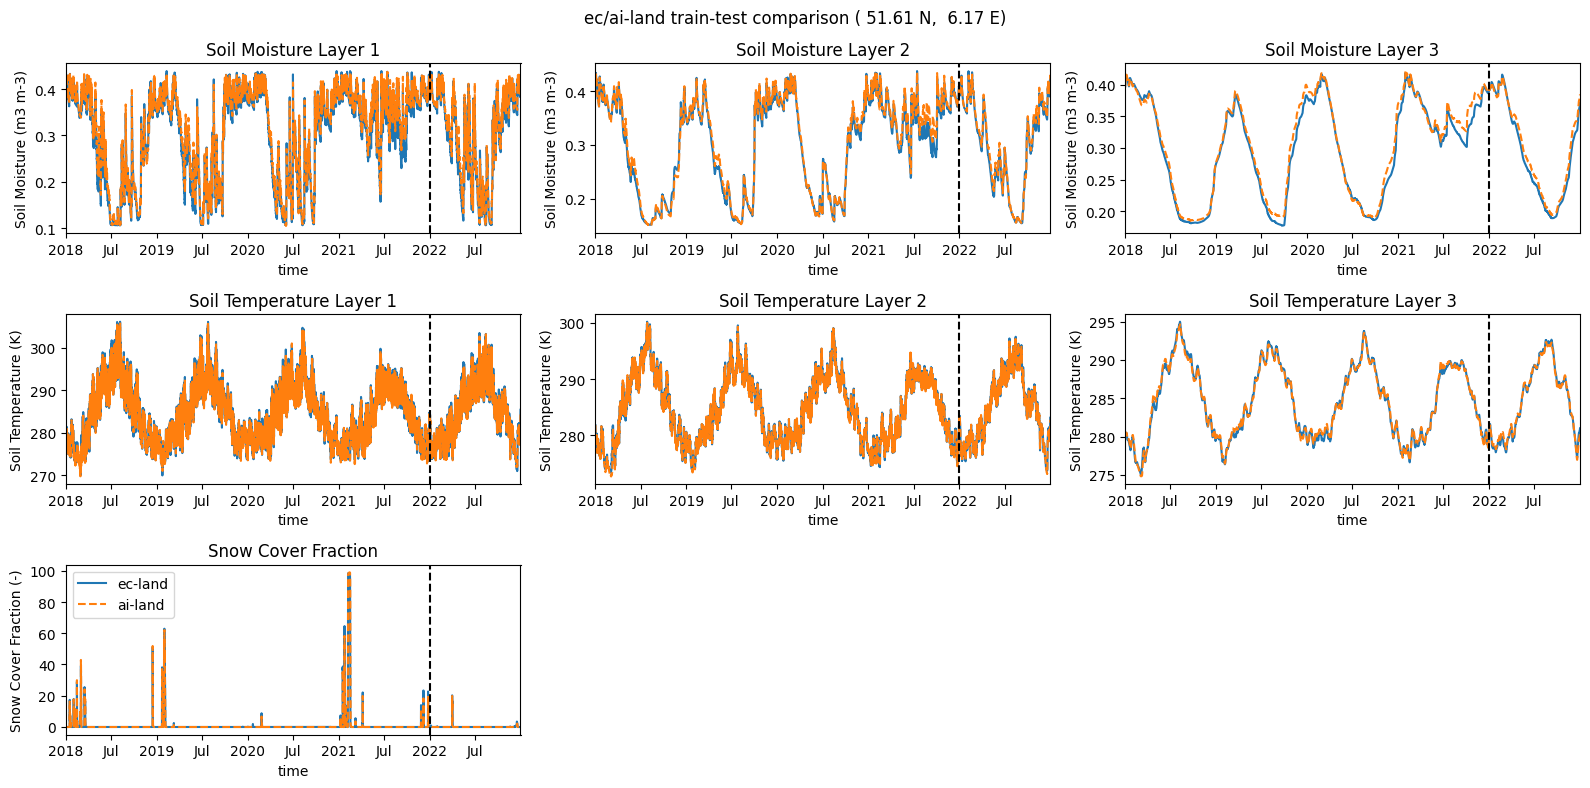

In [ ]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(331)
ax2 = plt.subplot(332)
ax3 = plt.subplot(333)
ax4 = plt.subplot(334)
ax5 = plt.subplot(335)
ax6 = plt.subplot(336)
ax7 = plt.subplot(337)

def ailand_plot(var_name, ax, ylabel, ax_title, test_date="2022-01-01"):
    """Plotting function for the ec-land database and ai-land model output

    :param var_name: parameter variable name
    :param ax: the axes to plot on
    :param ylabel: y-label for plot
    :param ax_title: title for plot
    :param test_date: date to plot vertical line (train/test split), defaults to "2022-01-01"
    :return: plot axes
    """
    feats[var_name].plot(label="ec-land", ax=ax)
    ax.plot(feats.time[:], feats_arr3[:, dataset.dynamic_feat_lst.index(var_name)], '--', label="ai-land")
    ax.axvline(feats.sel(time=test_date).time.values[0], color="k", linestyle="--")
    ax.set_xlim(feats.time.values[[0,-1]])
    ax.set_ylabel(ylabel)
    ax.set_title(ax_title)
    return ax

ailand_plot("swvl1", ax1, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 1")
ailand_plot("swvl2", ax2, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 2")
ailand_plot("swvl3", ax3, "Soil Moisture (m3 m-3)", "Soil Moisture Layer 3")
ailand_plot("stl1", ax4, "Soil Temperature (K)", "Soil Temperature Layer 1")
ailand_plot("stl2", ax5, "Soil Temperature (K)", "Soil Temperature Layer 2")
ailand_plot("stl3", ax6, "Soil Temperature (K)", "Soil Temperature Layer 3")
ailand_plot("snowc", ax7, "Snow Cover Fraction (-)", "Snow Cover Fraction")

plt.legend()
fig.suptitle(f"ec/ai-land train-test comparison ({feats.lat.values: .2f} N, {feats.lon.values: .2f} E)")
fig.tight_layout()